In [1]:
!pip install -q -U keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 5.8 MB/s eta 0:00:00


In [100]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from google.colab import drive
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
drive.mount('/content/drive')

In [ ]:
image_size = (128, 128)
crop_to_aspect_ratio = False
labels='inferred'
color_mode="rgb"
batch_size=16
label_mode="categorical"
shuffle=True
seed=42

In [5]:
ds_train = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/train",
                                        labels=labels,
                                        image_size=image_size,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        label_mode=label_mode,
                                        shuffle=shuffle,
                                        seed=seed
                                        )

ds_validation = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/validation",
                                             labels=labels,
                                             image_size=image_size,
                                             crop_to_aspect_ratio=crop_to_aspect_ratio,
                                             color_mode=color_mode,
                                             batch_size=batch_size,
                                             label_mode=label_mode,
                                             shuffle=shuffle,
                                             seed=seed
                                             )

ds_test = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/test",
                                       labels=labels, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,
                                       shuffle=shuffle,
                                       seed=seed
                                       )

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [6]:
input_shape = tuple(iter(ds_train).next()[0].shape[1:])

In [7]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")
# maybe we can explore different factors

----------------------------------------------

In [13]:
def model_builder2(hp):
    cnn = Sequential([# Input layer
        layers.Input((128,128,3)),
        # Data augmentation
        augmentation,
        # Data preprocessing
        layers.Rescaling(1./255),
        # 1st convLayer
        layers.Conv2D(
            filters=hp.Int('conv_1_num_filters', min_value=8, max_value=128, step=8),
            kernel_size=hp.Choice('conv_1_kernel_size', values = [2,3,4,5,6,7,8]),
            kernel_initializer=initializers.GlorotNormal(seed=42)
        ),
        layers.Activation(hp.Choice('1_activation', values=['relu', 'softmax', 'sigmoid'])),
        layers.MaxPooling2D(pool_size=hp.Choice('1_pool_size', values = [2,3,4])),
        # 2nd convLayer
        layers.Conv2D(
            filters=hp.Int('conv_2_num_filters', min_value=16, max_value=128, step=8),
            kernel_size=hp.Choice('conv_2_kernel_size', values = [2,3,4,5,6,7,8]),
            kernel_initializer=initializers.GlorotNormal(seed=42)
        ),
        layers.Activation(hp.Choice('2_activation', values=['relu', 'softmax', 'sigmoid'])),
        layers.MaxPooling2D(pool_size=hp.Choice('2_pool_size', values = [2,3,4])),
        # From a HxWxC cuboid to a (H*W*C) vector per image
        layers.Flatten(),
        # Classification (use units=n_classes, activation="softmax" for multi-class)
        layers.Dense(
            units=3,
            activation=hp.Choice('dense_activation', values=['relu', 'softmax', 'sigmoid']),
            kernel_initializer=initializers.GlorotNormal(seed=42)
        )
    ], name="CNN-V2_5")

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn.compile(loss="categorical_crossentropy",
    optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),  
    metrics=[
            metrics.CategoricalAccuracy(name='categorical_accuracy'),
            metrics.AUC(name='AUROC')
          ]
      )

    return cnn

In [14]:
tuner2 = kt.Hyperband(
    model_builder2,
    objective='val_categorical_accuracy',
    max_epochs=100,
    factor=3,
    directory='DL_project2',
    project_name='DL_project2')

In [15]:
stop_early = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

In [16]:
tuner2.search(ds_train, validation_data=ds_validation, epochs=100, callbacks=[stop_early])

Trial 254 Complete [00h 00m 17s]
val_categorical_accuracy: 0.3308270573616028

Best val_categorical_accuracy So Far: 0.9172932505607605
Total elapsed time: 00h 46m 00s


In [18]:
best_hps2=tuner2.get_best_hyperparameters(num_trials=1)[0]



In [24]:
model2 = tuner2.hypermodel.build(best_hps2)
history2 = model2.fit(ds_train, epochs=100, validation_data=ds_validation, callbacks=[stop_early])

val_acc_per_epoch2 = history2.history['val_categorical_accuracy']
best_epoch2 = val_acc_per_epoch2.index(max(val_acc_per_epoch2)) + 1
print('Best epoch: %d' % (best_epoch2,))

Epoch 1/100
65/65 [==============================] - 3s 20ms/step - loss: 1.1557 - categorical_accuracy: 0.4052 - AUROC: 0.5909 - val_loss: 0.9494 - val_categorical_accuracy: 0.5188 - val_AUROC: 0.7507
Epoch 2/100
65/65 [==============================] - 1s 17ms/step - loss: 0.9978 - categorical_accuracy: 0.5213 - AUROC: 0.6986 - val_loss: 1.1516 - val_categorical_accuracy: 0.4962 - val_AUROC: 0.7224
Epoch 3/100
65/65 [==============================] - 1s 17ms/step - loss: 0.9195 - categorical_accuracy: 0.5957 - AUROC: 0.7561 - val_loss: 0.9877 - val_categorical_accuracy: 0.5865 - val_AUROC: 0.7685
Epoch 4/100
65/65 [==============================] - 1s 16ms/step - loss: 0.8884 - categorical_accuracy: 0.5861 - AUROC: 0.7665 - val_loss: 0.6913 - val_categorical_accuracy: 0.6992 - val_AUROC: 0.8559
Epoch 5/100
65/65 [==============================] - 1s 16ms/step - loss: 0.8796 - categorical_accuracy: 0.6074 - AUROC: 0.7691 - val_loss: 0.9392 - val_categorical_accuracy: 0.5639 - val_AURO

In [39]:
best_hps2.values

{'conv_1_num_filters': 16,
 'conv_1_kernel_size': 6,
 '1_activation': 'relu',
 '1_pool_size': 2,
 'conv_2_num_filters': 56,
 'conv_2_kernel_size': 6,
 '2_activation': 'relu',
 '2_pool_size': 4,
 'dense_activation': 'sigmoid',
 'learning_rate': 0.0001,
 'optimizer': 'rmsprop',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0206'}

In [41]:
best_epoch2

65

In [76]:
stop_early_final = EarlyStopping(monitor='val_categorical_accuracy', patience=15)

In [77]:
hypermodel2 = tuner2.hypermodel.build(best_hps2)

# Retrain the model
history = hypermodel2.fit(ds_train, epochs=100, validation_data=ds_validation, callbacks=[stop_early_final])


Epoch 1/100
65/65 [==============================] - 3s 20ms/step - loss: 1.1310 - categorical_accuracy: 0.3985 - AUROC: 0.5831 - val_loss: 0.9659 - val_categorical_accuracy: 0.5188 - val_AUROC: 0.7390
Epoch 2/100
65/65 [==============================] - 1s 18ms/step - loss: 1.0069 - categorical_accuracy: 0.5426 - AUROC: 0.7092 - val_loss: 0.7819 - val_categorical_accuracy: 0.6541 - val_AUROC: 0.8086
Epoch 3/100
65/65 [==============================] - 1s 16ms/step - loss: 0.8994 - categorical_accuracy: 0.5812 - AUROC: 0.7431 - val_loss: 0.7790 - val_categorical_accuracy: 0.6767 - val_AUROC: 0.8251
Epoch 4/100
65/65 [==============================] - 1s 17ms/step - loss: 0.8755 - categorical_accuracy: 0.5928 - AUROC: 0.7573 - val_loss: 0.9943 - val_categorical_accuracy: 0.5338 - val_AUROC: 0.7648
Epoch 5/100
65/65 [==============================] - 1s 17ms/step - loss: 0.8779 - categorical_accuracy: 0.5841 - AUROC: 0.7599 - val_loss: 0.7227 - val_categorical_accuracy: 0.6992 - val_AURO

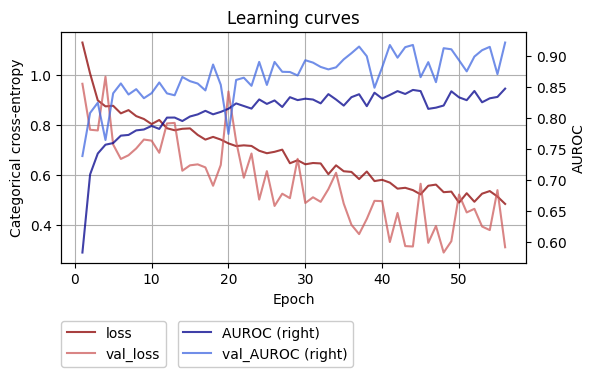

In [78]:
df_hist = pd.DataFrame.from_dict(history.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [79]:
eval_result2 = hypermodel2.evaluate(ds_test)
print("[test loss, categorical_accuracy, test accuracy]:", eval_result2)

8/8 [==============================] - 0s 5ms/step - loss: 0.3569 - categorical_accuracy: 0.8750 - AUROC: 0.9145
[test loss, categorical_accuracy, test accuracy]: [0.356941282749176, 0.875, 0.91448974609375]


In [80]:
hypermodel2.summary()

Model: "CNN-V2_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (None, 128, 128, 3)      0         
 equential)                                                      
                                                                 
 rescaling_13 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 123, 123, 16)      1744      
                                                                 
 activation_26 (Activation)  (None, 123, 123, 16)      0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 61, 61, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 56, 56, 56)        323

In [99]:
%cd /content/drive/MyDrive
%mkdir -p saved_model
hypermodel2.save('saved_model/CNN')

/content/drive/MyDrive


In [101]:
loaded_model = load_model("saved_model/CNN")

In [103]:
eval_result_loaded = loaded_model.evaluate(ds_test)
print("[test loss, categorical_accuracy, test accuracy]:", eval_result_loaded)

8/8 [==============================] - 0s 6ms/step - loss: 0.3569 - categorical_accuracy: 0.8750 - AUROC: 0.9145
[test loss, categorical_accuracy, test accuracy]: [0.3569413125514984, 0.875, 0.91448974609375]
